# Indonesia Peatland - Rapid Assessment

In [20]:
import rasterio
import geopandas as gpd
import pandas as pd
from tkinter import Tk, filedialog, simpledialog, messagebox
import rioxarray as rxr
import matplotlib.pyplot as plt
import geoplot as gplt
import geoplot.crs as gcrs
import contextily as ctx
import plotly.express as px
from matplotlib_scalebar.scalebar import ScaleBar

In [3]:
root = Tk() # pointing root to Tk() to use it as Tk() in program.
root.withdraw() # Hides small tkinter window.
root.attributes('-topmost', True) # Opened windows will be active. above all windows despite of selection.
roi_directory = filedialog.askopenfile(title = "Open RoI Shapefile") 
peat_directory = filedialog.askopenfile(title = "Open Peatland Shapefile")

In [4]:
# specify project name
projectname = simpledialog.askstring("Input", "Speficy project name",parent=root)

if projectname is not None:
    print("The script will assess ", projectname)
else:
    print("Name has not been submitted, Restart the code!")
    
#Specify Projection
projection = simpledialog.askstring("Input", "Specify Projection in UTM zone, example EPSG:3857", parent=root)

if projection is not None:
    print("All data will be reprojected to ", projection, ' canopy cover')
else:
    print("Projection has not specified, Restart the code!")
    
# column name for roi id
roi_column_name = simpledialog.askstring("Input", "Specify columns name in ROI attribute table to define boundary name",parent=root)

if roi_column_name is not None:
    print("Column name is ", roi_column_name)
else:
    print("Column has not identified, Restart the code!")

The script will assess  Kubu Raya RoI
All data will be reprojected to  EPSG:32749  canopy cover
Column name is  Village


In [5]:
# roi shapefile
roi = gpd.read_file(roi_directory.name)
peat = gpd.read_file(peat_directory.name)

roi_proj  = roi.to_crs(crs = projection)
peat_proj = peat.to_crs(crs = projection)

In [84]:
peat_proj['Depth'].unique().tolist()

['50-100 cm',
 '100-200 cm',
 '0',
 '200-400 cm',
 '400-800 cm',
 '> 400 cm',
 None,
 '< 50 cm',
 '200-300 cm']

In [6]:
peat_roi_proj = gpd.overlay(roi_proj, peat_proj, how='intersection')

In [7]:
peat_roi_proj['Area_Ha'] = peat_roi_proj['geometry'].area/ 10**6

In [71]:
peat_roi_proj_df = pd.DataFrame(peat_roi_proj)

In [73]:
peat_roi_proj_df_subset = peat_roi_proj_df[[roi_column_name, 'Depth', 'Area_Ha']]

In [75]:
peat_roi_proj_df_subset = peat_roi_proj_df_subset.groupby([ roi_column_name,'Depth'], as_index = False).sum()

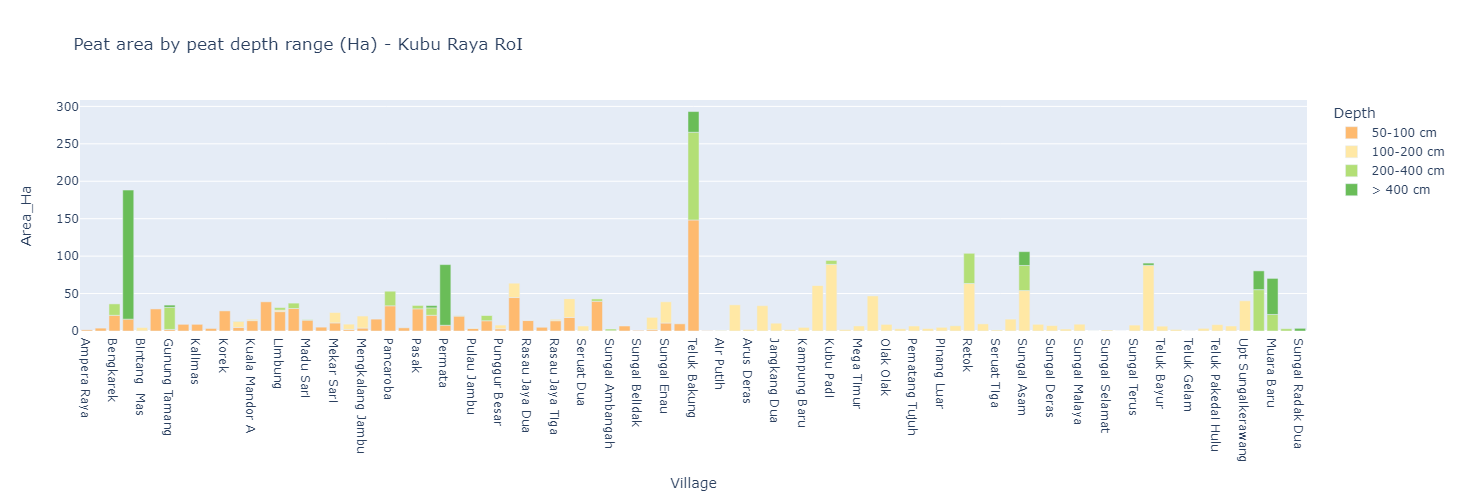

In [89]:
fig_peatarea_depth = px.bar(peat_roi_proj_df_subset, x = peat_roi_proj_df_subset.Village, 
                                         y =peat_roi_proj_df_subset.Area_Ha, color = 'Depth',
                                        category_orders={"Depth": ["0 cm", "< 50 cm", "50-100 cm", "100-200 cm", "200-300 cm","200-400 cm","> 400 cm", "400-800 cm"]},
                                        color_discrete_sequence = ['#d7191c', '#ed6e43', '#feba6f', '#ffe8a5', '#e6f5a8', '#b3df76', '#6abd58', '#1a9641'],
                                         width=1400, height=500, 
                   title ="Peat area by peat depth range (Ha) - " + projectname)
fig_peatarea_depth

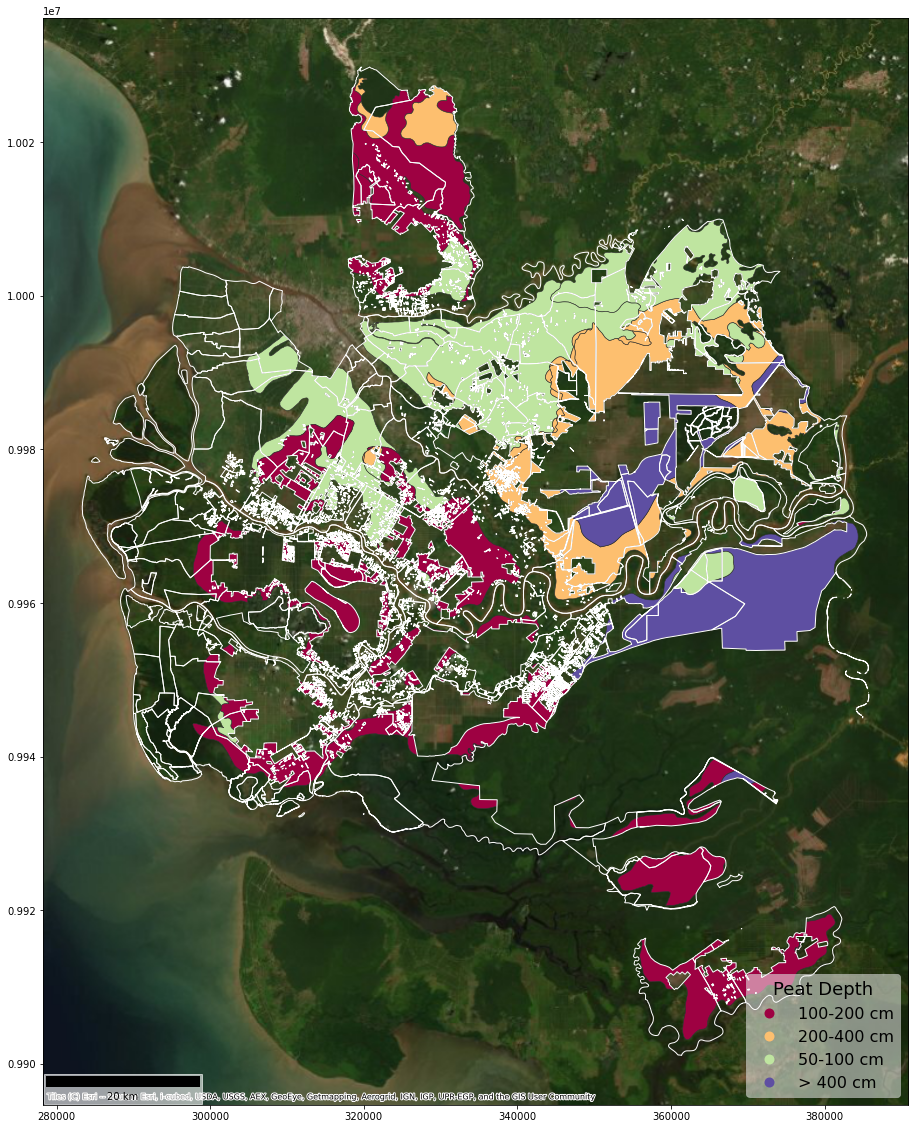

In [11]:
fig_peat, ax_peat= plt.subplots(figsize=(20,20))

# 1. Density ma
#gplt.webmap(df=roi_4326, 
#            projection=gcrs.WebMercator(), provider=ctx.providers.Esri.WorldImagery,
#            ax = ax_peat)
#gplt.polyplot(roi_4326, projection = gcrs.WebMercator(),
#             ax = ax_peat)
ax_peat.add_artist(ScaleBar(1, box_alpha=0.6, location = 'lower left'))
ax_peat = peat_roi_proj.plot(column='Depth', categorical=True, cmap='Spectral', linewidth=.6, edgecolor='0.2',
                             legend=True, 
                             legend_kwds={'fontsize':16,'frameon':False, 'loc': 'lower right', 'title' : 'Peat Depth', 'title_fontsize' : 18, 'frameon': True, 'framealpha':0.5}, 
                             ax = ax_peat)
ax_peat = roi_proj.plot(color = None, edgecolor = 'white', facecolor="none", ax = ax_peat)
ax_peat = ctx.add_basemap(source=ctx.providers.Esri.WorldImagery, crs=roi_proj.crs.to_string(), ax = ax_peat)